In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import math
import numpy as np
from collections import Counter
from sklearn import metrics

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_regression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

In [2]:
def final_df():
    df = pd.read_csv("../data/final_df/boost.csv")
    df.drop(columns="Unnamed: 0", inplace = True)
    df = df[(df["message"].str.lower() != "\u200eaudio ") & (df["message"].str.lower() != "\u200evideo ")& (df["message"].str.lower() != "\u200eimage ")]
    df.reset_index(drop=True, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df["emotions_names"] = df["emotions_names"].replace("hapiness","happiness")
    df["emotions_names"] = df["emotions_names"].replace("deception","disappointment")
    df.to_csv("../data/transformed_df/emsemotions.csv")
    return df

In [3]:
df = final_df()
df

,date,time,name,message,emotions,emotions_names
0,2017-04-18,23:45:15,Em,A saludarte,8,happiness
1,2017-04-18,23:47:58,Em,Es que aún tengo que comer,8,happiness
2,2017-04-18,23:48:53,Em,Okaaaay,8,happiness
3,2017-04-18,23:49:14,Em,Teee amo,8,happiness
4,2017-04-18,23:49:49,Em,Nos vemos luego,8,happiness
...,...,...,...,...,...,...
95109,2023-11-27,15:11:36,Em,https://email.ionos.es/appsuite/help/l10n/es_E...,13,neutral
95110,2023-11-27,15:11:59,Em,Aquí lambe,8,happiness
95111,2023-11-27,15:12:01,Em,https://www.ionos.mx/ayuda/e-mail/glosario-exp...,13,neutral
95112,2023-11-27,15:13:08,Em,Aquest crec que es el mes clar:,9,stressed


<Axes: xlabel='emotions', ylabel='count'>

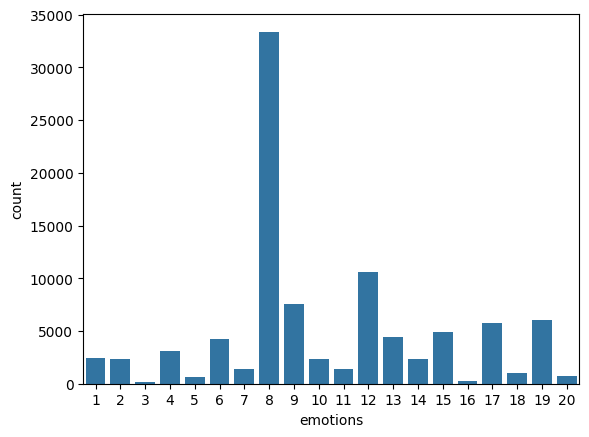

In [4]:
sns.countplot(x=df.emotions)

In [5]:
df.sample()

,date,time,name,message,emotions,emotions_names
87419,2023-03-29,21:05:03,Em,Perfecte amb lo dels textos:),12,assertivity


In [6]:
df.dtypes

date              datetime64[ns]
time                      object
name                      object
message                   object
emotions                   int64
emotions_names            object
dtype: object

In [7]:
emotion_weights = {
    "assertivity": 0.2,
    "happiness": 0.4,
    "neutral": 0.2,
    "defensive": 0.4
}

## DAILY EMOTIONS

In [8]:
def ponderations(df):

    '''Function to designate the max emotion grupping be day.
    It also creates the day of the week and if it's a weekend or weekday.'''

    emotion_weights = {
        "assertivity": 0.2,
        "happiness": 0.3,
        "neutral": 0.2,
        "defensive": 0.4
    }

    df['ponderation'] = df['emotions_names'].map(emotion_weights).fillna(1.0)
    grouped_df = df.groupby(['date', 'emotions_names']).agg({'ponderation': 'sum'}).reset_index()

    weighted_percentage_df = grouped_df.pivot(index='date', columns='emotions_names', values='ponderation').fillna(0)
    weighted_percentage_df = weighted_percentage_df.div(weighted_percentage_df.sum(axis=1), axis=0) * 100

    max_emotion_df = weighted_percentage_df.idxmax(axis=1).reset_index(name='max_emotion')

    max_emotion_df['day_of_week'] = max_emotion_df['date'].dt.day_name()

    max_emotion_df['end_day'] = max_emotion_df['day_of_week'].map(lambda x: 'WeekEND' if x in ['Saturday', 'Sunday'] else 'WeekDAY')

    max_emotion_df.reset_index(drop=True, inplace=True)

    max_emotion_df.to_csv("../data/transformed_df/daylyemotions.csv")

    return max_emotion_df

day = ponderations(df)

In [3]:
day = pd.read_csv("../data/transformed_df/daylyemotions.csv")
day.sample(5)

,Unnamed: 0,date,max_emotion,day_of_week,end_day
1238,1238,2020-09-24,expectant,Thursday,WeekDAY
349,349,2018-04-10,love,Tuesday,WeekDAY
1442,1442,2021-04-16,happiness,Friday,WeekDAY
814,814,2019-07-28,disappointment,Sunday,WeekEND
324,324,2018-03-16,doubtful,Friday,WeekDAY


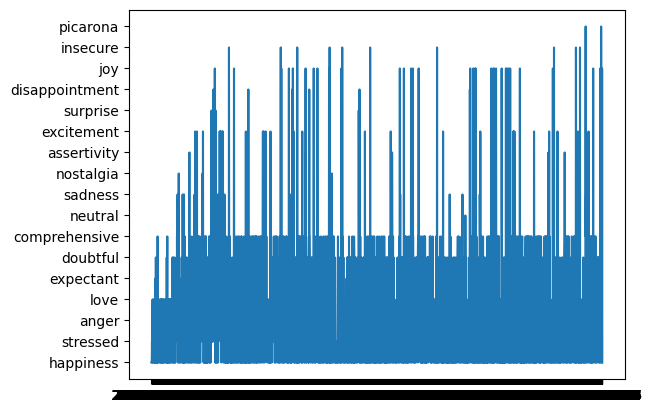

In [4]:
plt.plot(day["date"], day["max_emotion"])
plt.show();

Nice to have si el dia es finde o no

In [10]:
day.max_emotion.value_counts()

max_emotion
happiness         921
stressed          384
doubtful          292
love              273
comprehensive     221
anger              83
expectant          40
joy                34
excitement         32
sadness            15
insecure           10
disappointment      6
assertivity         5
nostalgia           3
surprise            3
neutral             2
picarona            2
Name: count, dtype: int64

## WEEKLY EMOTIONS

In [11]:
def week_emotions(df):

    '''Function to designate the max emotion grupping be day.
    It also creates the day of the week and if it's a weekend or weekday.'''

    emotion_weights = {
        "assertivity": 0.2,
        "happiness": 0.3,
        "neutral": 0.2,
        "defensive": 0.4
    }

    df['ponderation'] = df['emotions_names'].map(emotion_weights).fillna(1.0)
    df['week'] = df['date'].dt.strftime('%Y-%U')
    grouped_df = df.groupby(['week', 'emotions_names']).agg({'ponderation': 'sum'}).reset_index()

    weighted_percentage_df = grouped_df.pivot(index='week', columns='emotions_names', values='ponderation').fillna(0)
    weighted_percentage_df = weighted_percentage_df.div(weighted_percentage_df.sum(axis=1), axis=0) * 100

    max_emotion_df = weighted_percentage_df.idxmax(axis=1).reset_index(name='max_emotion')

    max_emotion_df.reset_index(drop=True, inplace=True)

    max_emotion_df.to_csv("../data/transformed_df/weeklyemotions.csv")

    return max_emotion_df

week = week_emotions(df)

In [12]:
week

,week,max_emotion
0,2017-16,happiness
1,2017-17,love
2,2017-18,happiness
3,2017-19,love
4,2017-20,happiness
...,...,...
338,2023-44,stressed
339,2023-45,stressed
340,2023-46,happiness
341,2023-47,happiness


In [13]:
week.columns

Index(['week', 'max_emotion'], dtype='object')

In [14]:
week.tail(20)

,week,max_emotion
323,2023-29,stressed
324,2023-30,happiness
325,2023-31,happiness
326,2023-32,happiness
327,2023-33,happiness
328,2023-34,happiness
329,2023-35,happiness
330,2023-36,happiness
331,2023-37,happiness
332,2023-38,happiness


In [15]:
week.max_emotion.value_counts()

max_emotion
happiness        259
stressed          44
love              28
doubtful           8
comprehensive      4
Name: count, dtype: int64

## MONTHLY EMOTIONS

In [16]:
def month_emotions(df):

    '''Function to designate the max emotion grupping be day.
    It also creates the day of the week and if it's a weekend or weekday.'''

    emotion_weights = {
        "assertivity": 0.2,
        "happiness": 0.25,
        "neutral": 0.2,
        "defensive": 0.4
    }

    df['ponderation'] = df['emotions_names'].map(emotion_weights).fillna(1.0)
    df['month'] = df['date'].dt.to_period('M')
    grouped_df = df.groupby(['month', 'emotions_names']).agg({'ponderation': 'sum'}).reset_index()

    weighted_percentage_df = grouped_df.pivot(index='month', columns='emotions_names', values='ponderation').fillna(0)
    weighted_percentage_df = weighted_percentage_df.div(weighted_percentage_df.sum(axis=1), axis=0) * 100

    max_emotion_df = weighted_percentage_df.idxmax(axis=1).reset_index(name='max_emotion')

    max_emotion_df.reset_index(drop=True, inplace=True)

    max_emotion_df.to_csv("../data/transformed_df/monthlyemotions.csv")

    return max_emotion_df

month = month_emotions(df)

In [17]:
month

,month,max_emotion
0,2017-04,happiness
1,2017-05,love
2,2017-06,happiness
3,2017-07,love
4,2017-08,love
...,...,...
75,2023-07,stressed
76,2023-08,happiness
77,2023-09,happiness
78,2023-10,happiness


In [18]:
month.max_emotion.value_counts()

max_emotion
happiness    54
stressed     18
love          7
doubtful      1
Name: count, dtype: int64

In [5]:
month = pd.read_csv("../data/transformed_df/monthlyemotions.csv")
month

,Unnamed: 0,month,max_emotion
0,0,2017-04,happiness
1,1,2017-05,love
2,2,2017-06,happiness
3,3,2017-07,love
4,4,2017-08,love
...,...,...,...
75,75,2023-07,stressed
76,76,2023-08,happiness
77,77,2023-09,happiness
78,78,2023-10,happiness


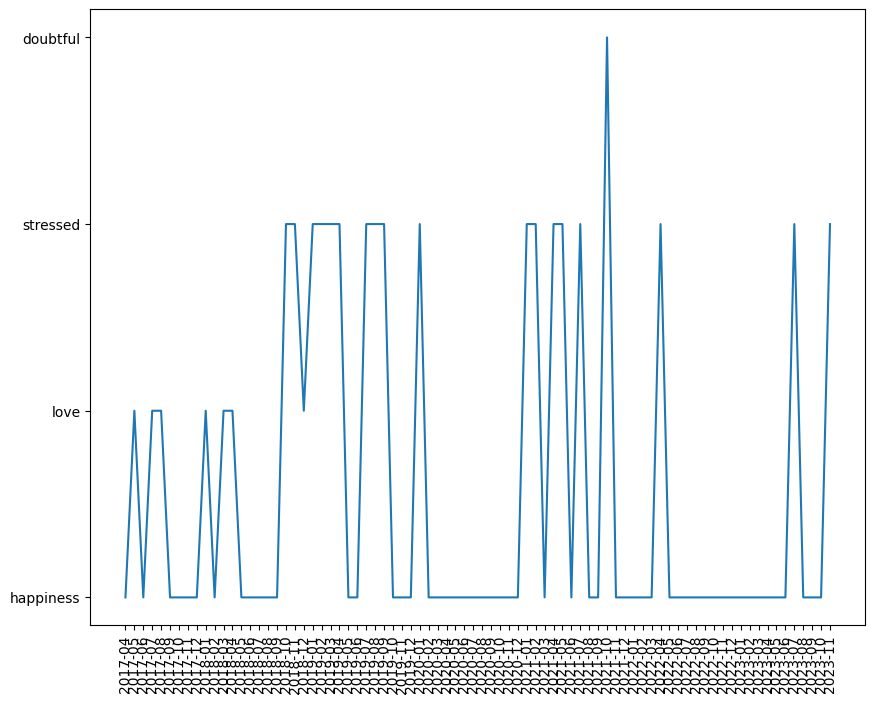

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(month["month"], month["max_emotion"])
plt.xticks(rotation=90)
plt.show();

In [25]:

fig = px.line_polar(
    month,
    r=month["max_emotion"].value_counts().values,
    theta=month["max_emotion"].value_counts().index,
    line_close=True,
)
fig.update_traces(fill='toself')
fig.show()


## GET DATTAFRAME WE'LL USE TO PREDICT

In [129]:
def predict_emotion_df(df):

    '''Function to get the dataframe we're going to use to train and test the model and predict
    the emotion of the month we're entering based on the last week of the month messages.'''


    df2 = df.copy()

    df2['year'] = df2['date'].dt.year
    df2['month'] = df2['date'].dt.month

    # messages, only from the 7 days of every month
    last_day_of_month = df2.groupby(['year', 'month'])['date'].max().reset_index()
    last_day_of_month['last_7_days'] = last_day_of_month['date'] - pd.DateOffset(days=6)
    last_day_of_month['last_7_days'] = last_day_of_month['last_7_days'].dt.date
    result_df = pd.merge(df2, last_day_of_month, on=['year', 'month'], how='inner', suffixes=('', '_max'))
    result_df = result_df[result_df['date'] >= result_df['last_7_days']]
    result_df.drop(['year', 'month', 'date_max', 'last_7_days','name', 'ponderation', 'message'], axis=1, inplace = True)
    result_df['week'] = result_df['date'].dt.to_period('M')
    result_df.rename(columns={'week': 'month'}, inplace=True)

    # days
    df3 = day.copy()
    df3.rename(columns={'max_emotion': 'max_emotion_day'}, inplace=True)
    df3.drop(['day_of_week', 'end_day'], axis=1, inplace=True)
    merged_df = pd.merge(result_df,df3, on='date', how='right')

    # weeks
    df4 = week.copy()
    print(df4.dtypes)
    df4['week'] = pd.to_datetime(df4['week'] + '-1', format='%Y-%U-%w')
    df4['week'] = df4['week'].dt.to_period('M')
    df4.rename(columns={'max_emotion': 'max_emotion_week'}, inplace=True)
    df4.rename(columns={'week': 'month'}, inplace=True)
    merged_df2 = pd.merge(merged_df, df4, on='month', how='right')

    # month
    df5 = month.copy()
    df5.rename(columns={'max_emotion': 'next_month_emotion'}, inplace=True)   
    merged_df2['month'] = merged_df2['month']+ 1 #+ pd.DateOffset(months=1)+ pd.DateOffset(days=1)
    merged_df3 = pd.merge(merged_df2, df5, on='month', how='right', suffixes=('_merged_df2', '_df5'))

    merged_df3['month'] = merged_df2['month']- 1
    merged_df3.drop(['month','emotions_names'], axis=1, inplace = True)
    merged_df3.dropna(subset=['next_month_emotion'], inplace = True)
    merged_df3.dropna(subset=['next_month_emotion'], inplace = True)
    merged_df3.dropna(subset=['date'], inplace = True)

    merged_df3 = merged_df3.reset_index(drop=True)


    # changing the words for numbers

    emotions = {"sadness":1,"joy":2,"fear":3,"anger":4,"surprise":5,"defensive":6, "nostalgia":7,"happiness":8,"stressed":9,
                "expectant":10,"insecure":11,"assertivity":12,"neutral":13,"excitement":14,"comprehensive":15,
                "helpless":16,"love":17,"disappointment":18,"doubtful":19,"picarona":20}

    columns_to_replace = ["max_emotion_day", "max_emotion_week", "next_month_emotion"]

    for column in columns_to_replace:
        merged_df3[column] = merged_df3[column].replace(emotions)



    merged_df3.to_csv("../data/transformed_df/pdef.csv")

    
    # Display the result
    return merged_df3



In [130]:
pedf = predict_emotion_df(df)
pedf

week           object
max_emotion    object
dtype: object


,date,time,emotions,max_emotion_day,max_emotion_week,next_month_emotion
0,2017-04-24,00:35:19,9.0,17,8,17
1,2017-04-24,00:35:33,19.0,17,8,17
2,2017-04-24,00:35:42,8.0,17,8,17
3,2017-04-24,10:53:34,9.0,17,8,17
4,2017-04-24,10:53:37,8.0,17,8,17
...,...,...,...,...,...,...
96160,2023-10-31,10:32:52,19.0,19,9,9
96161,2023-10-31,10:34:27,19.0,19,9,9
96162,2023-10-31,19:42:34,6.0,19,9,9
96163,2023-10-31,19:42:40,4.0,19,9,9


In [77]:
pedf.isna().sum()

date                  0
time                  0
emotions              0
max_emotion_day       0
max_emotion_week      0
next_month_emotion    0
dtype: int64

## GET DATAFRAME TO UNKNOWN PREDICTION

In [131]:
def final_emotion_df(df):

    '''Function to get the dataframe with nans to the last messages to really predict the next month emotion.'''


    df2 = df.copy()

    df2['year'] = df2['date'].dt.year
    df2['month'] = df2['date'].dt.month

    # messages, only from the 7 days of every month
    last_day_of_month = df2.groupby(['year', 'month'])['date'].max().reset_index()
    last_day_of_month['last_7_days'] = last_day_of_month['date'] - pd.DateOffset(days=6)
    last_day_of_month['last_7_days'] = last_day_of_month['last_7_days'].dt.date
    result_df = pd.merge(df2, last_day_of_month, on=['year', 'month'], how='inner', suffixes=('', '_max'))
    result_df = result_df[result_df['date'] >= result_df['last_7_days']]
    result_df.drop(['year', 'month', 'date_max', 'last_7_days','name', 'ponderation', 'message'], axis=1, inplace = True)
    result_df['week'] = result_df['date'].dt.to_period('M')
    result_df.rename(columns={'week': 'month'}, inplace=True)

    # days
    df3 = day.copy()
    df3.rename(columns={'max_emotion': 'max_emotion_day'}, inplace=True)
    df3.drop(['day_of_week', 'end_day'], axis=1, inplace=True)
    merged_df = pd.merge(result_df,df3, on='date', how='right')

    # weeks
    df4 = week.copy()
    print(df4.dtypes)
    df4['week'] = pd.to_datetime(df4['week'] + '-1', format='%Y-%U-%w')
    df4['week'] = df4['week'].dt.to_period('M')
    df4.rename(columns={'max_emotion': 'max_emotion_week'}, inplace=True)
    df4.rename(columns={'week': 'month'}, inplace=True)
    merged_df2 = pd.merge(merged_df, df4, on='month', how='right')

    # month
    df5 = month.copy()
    df5.rename(columns={'max_emotion': 'next_month_emotion'}, inplace=True)   
    merged_df2['month'] = merged_df2['month']+ 1 #+ pd.DateOffset(months=1)+ pd.DateOffset(days=1)
    merged_df3 = pd.merge(merged_df2, df5, on='month', how='left', suffixes=('_merged_df2', '_df5'))

    merged_df3['month'] = merged_df2['month']- 1
    merged_df3.drop(['month','emotions_names'], axis=1, inplace = True)
    merged_df3.dropna(subset=['date'], inplace = True)

    merged_df3 = merged_df3.reset_index(drop=True)


    # changing the words for numbers

    emotions = {"sadness":1,"joy":2,"fear":3,"anger":4,"surprise":5,"defensive":6, "nostalgia":7,"happiness":8,"stressed":9,
                "expectant":10,"insecure":11,"assertivity":12,"neutral":13,"excitement":14,"comprehensive":15,
                "helpless":16,"love":17,"disappointment":18,"doubtful":19,"picarona":20}

    columns_to_replace = ["max_emotion_day", "max_emotion_week", "next_month_emotion"]

    for column in columns_to_replace:
        merged_df3[column] = merged_df3[column].replace(emotions)



    merged_df3.to_csv("../data/transformed_df/fdf.csv")

    
    # Display the result
    return merged_df3

In [132]:
fdf = final_emotion_df(df)
fdf

week           object
max_emotion    object
dtype: object


,date,time,emotions,max_emotion_day,max_emotion_week,next_month_emotion
0,2017-04-24,00:35:19,9.0,17,8,17.0
1,2017-04-24,00:35:33,19.0,17,8,17.0
2,2017-04-24,00:35:42,8.0,17,8,17.0
3,2017-04-24,10:53:34,9.0,17,8,17.0
4,2017-04-24,10:53:37,8.0,17,8,17.0
...,...,...,...,...,...,...
96536,2023-11-27,15:11:36,13.0,8,8,NaN
96537,2023-11-27,15:11:59,8.0,8,8,NaN
96538,2023-11-27,15:12:01,13.0,8,8,NaN
96539,2023-11-27,15:13:08,9.0,8,8,NaN


In [133]:
fdf.isna().sum()

date                    0
time                    0
emotions                0
max_emotion_day         0
max_emotion_week        0
next_month_emotion    376
dtype: int64

## MACHINE LEARNING

In [111]:
def pred_next_mont(df,model, test_size=0.2):

    '''Function to find the best model to predict.'''

    X = df.drop(columns=["next_month_emotion", "time", "date"])
    y = df["next_month_emotion"]
    
    # 0. Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    print(f"------------notas------------\n")
    print(f"Precision: {metrics.precision_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print(f"Recall: {metrics.recall_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print(f"F1 Score: {metrics.f1_score(y_test, y_pred, average='weighted',zero_division=1):.4f}")
    print("\n")
    

In [79]:
knei = pred_next_mont(pedf,KNeighborsClassifier(), test_size=0.2)

            date      time  emotions  max_emotion_day  max_emotion_week  \
0     2017-04-24  00:35:19       9.0               17                 8   
1     2017-04-24  00:35:33      19.0               17                 8   
2     2017-04-24  00:35:42       8.0               17                 8   
3     2017-04-24  10:53:34       9.0               17                 8   
4     2017-04-24  10:53:37       8.0               17                 8   
...          ...       ...       ...              ...               ...   
96160 2023-10-31  10:32:52      19.0               19                 9   
96161 2023-10-31  10:34:27      19.0               19                 9   
96162 2023-10-31  19:42:34       6.0               19                 9   
96163 2023-10-31  19:42:40       4.0               19                 9   
96164 2023-10-31  19:42:48       6.0               19                 9   

       next_month_emotion  
0                      17  
1                      17  
2              

In [110]:
tree = pred_next_mont(pedf,DecisionTreeClassifier(splitter = 'best', min_samples_split= 10, min_samples_leaf= 5, max_depth= 50, criterion='entropy'), test_size=0.2)

------------notas------------

Precision: 0.6446
Recall: 0.6612
F1 Score: 0.5872




## APPLY MODEL TO DF

In [112]:
emotions2 = {1: 'sadness',
 2: 'joy',
 3: 'fear',
 4: 'anger',
 5: 'surprise',
 6: 'defensive',
 7: 'nostalgia',
 8: 'hapiness',
 9: 'stressed',
 10: 'expectant',
 11: 'insecure',
 12: 'assertivity',
 13: 'neutral',
 14: 'excitement',
 15: 'comprehensive',
 16: 'helpless',
 17: 'love',
 18: 'deception',
 19: 'doubtful',
 20: 'picarona'}

In [122]:
def apply_pred(df,model, test_size=0.2):

    '''Function to predict the next month emotion.'''

    X = df.drop(columns=["next_month_emotion", "time", "date"])
    y = df["next_month_emotion"]
    
    # 0. Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    plot1 = sns.countplot(x = y_test)
    plot2 = sns.countplot(x = y_pred)

    return df, plot1, plot2


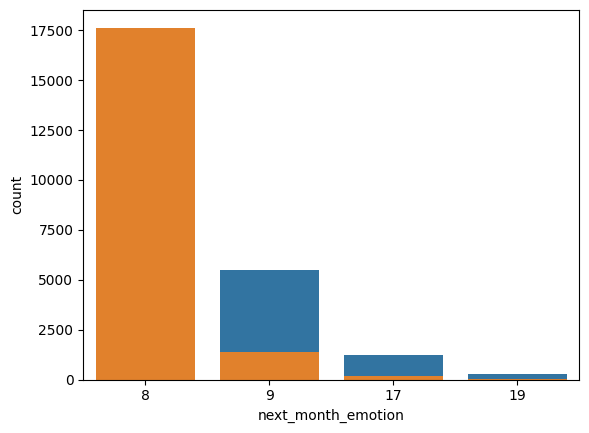

In [124]:
final = apply_pred(pedf,DecisionTreeClassifier(), test_size=0.2)

A tableau o a streamlit fer que et surti la emocio...
Trained a model to predict the next month emotion
En el dataframe le entras las nuevas emociones de cada mensaje y lo hace

## APPLY MODEL TO GET DECEMBER'S PREDICTION

In [178]:
def final_pred(df,model, test_size=0.2):

    '''Function to predict the next month emotion.'''

    #test_size = fdf.next_month_emotion.isna().sum()/fdf.shape[0]*100
    test_data =df.tail(376)
    train_data = df.dropna(subset=['next_month_emotion'])

    X = train_data.drop(columns=["next_month_emotion", "time", "date"])
    y = train_data["next_month_emotion"]
    
    # 0. Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model Accuracy: {accuracy}')

    X_test = test_data.drop(columns=["next_month_emotion", "time", "date"], axis=1)
    y_test_pred = model.predict(X_test)

    df.loc[df["next_month_emotion"].tail(376), 'next_month_emotion'] = y_test_pred
    
    y_test_pred_int = y_test_pred.astype(int)

    y_pred_names = [emotions2[i] for i in y_test_pred_int if i in emotions2]
    
    counter = Counter(y_pred_names)

    print(f"Looks like the next month your main emotion will be: {counter.most_common(1)[0][0]} ")


    return df

In [143]:
fdf

,date,time,emotions,max_emotion_day,max_emotion_week,next_month_emotion
0,2017-04-24,00:35:19,9.0,17,8,17.0
1,2017-04-24,00:35:33,19.0,17,8,17.0
2,2017-04-24,00:35:42,8.0,17,8,17.0
3,2017-04-24,10:53:34,9.0,17,8,17.0
4,2017-04-24,10:53:37,8.0,17,8,17.0
...,...,...,...,...,...,...
96536,2023-11-27,15:11:36,13.0,8,8,NaN
96537,2023-11-27,15:11:59,8.0,8,8,NaN
96538,2023-11-27,15:12:01,13.0,8,8,NaN
96539,2023-11-27,15:13:08,9.0,8,8,NaN


In [181]:
next_mont_prediction_df = final_pred(fdf,DecisionTreeClassifier(), test_size=0.2)

Model Accuracy: 0.6668910870578487
Looks like the next month your main emotion will be: hapiness 


In [187]:
next_mont_prediction_df

,date,time,emotions,max_emotion_day,max_emotion_week,next_month_emotion
0,2017-04-24,00:35:19,9.0,17,8,17.0
1,2017-04-24,00:35:33,19.0,17,8,17.0
2,2017-04-24,00:35:42,8.0,17,8,17.0
3,2017-04-24,10:53:34,9.0,17,8,17.0
4,2017-04-24,10:53:37,8.0,17,8,17.0
...,...,...,...,...,...,...
96536,2023-11-27,15:11:36,13.0,8,8,8.0
96537,2023-11-27,15:11:59,8.0,8,8,8.0
96538,2023-11-27,15:12:01,13.0,8,8,8.0
96539,2023-11-27,15:13:08,9.0,8,8,8.0
